## Feature Engineering 

In [24]:
import numpy as np
import pandas as pd
from scipy import stats
import modules.help_functions as hf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE

import pickle

from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt


In [15]:
# read in file
df = pd.read_csv('../data/flights.csv')
df_delays = hf.get_avg_delay(df, ['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'])

In [9]:
def convert_testtrain_data_to_test_format(df):
    """ Convert our testing data to be in the same format as the data to test (drop columns and reformat date)"""
    
    #convert date to datetime with 0's
    df.fl_date = (df.fl_date + ' 00:00:00')
    pd.to_datetime(df['fl_date'])
    
    #drop columns not present in test format
    df.drop(columns=['dep_time',
       'dep_delay', 'taxi_out', 'wheels_off', 'wheels_on', 'taxi_in', 'arr_time', 'cancelled',
       'cancellation_code', 'diverted', 'actual_elapsed_time', 'air_time', 
       'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay',
       'late_aircraft_delay', 'first_dep_time', 'total_add_gtime',
       'longest_add_gtime','no_name'], inplace = True)
    return df


0.0

In [82]:
def convert_from_test_format_to_fit_predict_format(df):
    """Adds in columns for model fitting and converts to numeric/ encoded categorical for ML model"""
    
    # Split crs_arr_time and crs_dep_time into hour of day (local)
    df = hf.split_time_of_day_departure(df)
    df = hf.split_time_of_day_arrival(df)
    df.drop(columns=['crs_dep_time', 'crs_arr_time'], inplace=True)
    
    #take log distance
    df['distance_log'] = np.log(df.distance)
    df.drop(columns=['distance'], inplace=True)
    
    # encode hour of day departure
    f = lambda x: str(int(np.floor(x)))
    df['dep_hour'] = df['dep_hour'].apply(f)
    df['arr_hour'] = df['arr_hour'].apply(f)
    df = hf.encode_and_bind(df, 'dep_hour')
    df = hf.encode_and_bind(df, 'arr_hour')
 
    # Convert fl_date into day of week  # NOTE MAY WANT TO ADD BACK IN MONTH OR JAN 1 days
    df = hf.add_weekday(df)  
    df.drop(columns=['fl_date'], inplace=True)
    df = hf.encode_and_bind(df, 'weekday')
    
    # Add average delays to dest
    df = df.merge(df_delays, on='dest', how='left')
    
    # Split city and state 
    hf.split_origin_city_state(df)
    hf.split_dest_city_state(df)
    df.drop(columns=['dest_city_name', 'origin_city_name'], inplace=True)
    
    # Encode top 10 cities in terms of traffic
    city_list = ['Chicago','Atlanta','New York','Dallas/Fort Worth','Denver','Charlotte','Houston','Washington','Los Angeles','Seattle']
    df.dest_city = np.where(df.dest_city.isin(city_list),df.dest_city, '0')
    df.origin_city = np.where(df.origin_city.isin(city_list),df.origin_city, '0')
    df = hf.encode_and_bind(df, 'origin_city')
    df = hf.encode_and_bind(df, 'dest_city')
    df.drop(columns=['dest_city', 'origin_city'], inplace=True)
    
    #Top 20 airport codes
    top20_airport_code = ['LAX', 'ORD', 'EWR', 'SFO', 'LGA', 'DFW', 'LAS', 'CLT', 'DEN',
                      'PHL', 'IAH', 'SEA', 'ATL', 'PHX', 'MCO', 'DTW', 'SLC', 'BOS',
                      'JFK', 'MSP']
    df.dest = np.where(df.dest.isin(top20_airport_code),df.dest, '0')
    df.origin = np.where(df.origin.isin(top20_airport_code),df.origin, '0')
    df = hf.encode_and_bind(df, 'dest')
    df = hf.encode_and_bind(df, 'origin')
    
    #REMOVE negative targets (arr_delay - set to zero)
#     df.arr_delay = np.where(df.arr_delay >0,df.arr_delay, 0)
    
    # State - Encode (based on # flights)
    state_list = ['CA','TX', 'FL', 'IL', 'NY', 'GA', 'NC', 'CO', 'PA', 'WA']
    df.dest_state = np.where(df.dest_state.isin(state_list),df.dest_state, '0')
    df.origin_state = np.where(df.origin_state.isin(state_list),df.origin_state, '0')
    df = hf.encode_and_bind(df, 'origin_state')
    df = hf.encode_and_bind(df, 'dest_state')
    df.drop(columns=['dest_state', 'origin_state'], inplace=True)
          
    # Convert Airline Carrier - Encode 
    df = hf.encode_and_bind(df, 'mkt_unique_carrier')
    df.drop(columns = ['mkt_unique_carrier'], inplace=True)

    # Origin Airport - Encode top 10 (rest in 'other') OR BIN according to passenger or flight volume
    df = hf.make_col_value_bins(df, 'origin', 'origin_airport_fl_amt_bin', 7) 
    
    
    # Dest Airport - Encode top 10 or bin according to passenger of flight volume 
    df = hf.make_col_value_bins(df, 'dest', 'dest_airport_fl_amt_bin', 7) 
   
    # Flight number ??? # drop for now? 
    df.drop(columns = ['mkt_carrier_fl_num'], inplace=True)
    
    # crs_elapsed # USE LONG HAUL SHORT HAUL
    df['log_crs_elapsed_time'] = np.log(df.crs_elapsed_time)
    df = hf.make_bin_column(df, 'log_crs_elapsed_time', 20) # 8-2/0.3
    df.drop(columns = ['crs_elapsed_time','log_crs_elapsed_time' ], inplace=True)

    # Drop rest
    df.drop(columns=['branded_code_share', 'mkt_carrier','op_unique_carrier', 'tail_num', 
                     'op_carrier_fl_num', 'dep_hour', 'origin_airport_id', 'arr_hour','dest_airport_id',  'dup', 'flights'], errors='ignore', inplace = True)


    return df

In [83]:
def load_preprocessed_data():
    """ read in data file, convert to the format the given test data is in and add / format columns per feature engineering """
   
    df = pd.read_csv('../data/flights.csv')
    
    # remove non-landing flights
    df.dropna(subset=['arr_delay'], inplace=True)
    
#     remove outliers ### IS THIS GOING TO BACKFIRE?
#     df_rm = df_rm[(np.abs(stats.zscore(df_rm['arr_delay'])) < 3)]
    cols = ['arr_delay'] 
    Q1 = df[cols].quantile(0.25)
    Q3 = df[cols].quantile(0.75)
    IQR = Q3 - Q1
    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # convert
    df = convert_testtrain_data_to_test_format(df)
    df = convert_from_test_format_to_fit_predict_format(df)
    return df

In [84]:
df = load_preprocessed_data()

### Scale

In [75]:
# list(df.columns)

In [85]:
# rescale the features
# scaler = MinMaxScaler()
scaler = StandardScaler()

# apply scaler() to all the numeric columns 
numeric_vars = ['avg_carrier_delay', 
                 'avg_weather_delay', 
                 'avg_nas_delay', 
                 'avg_security_delay', 
                 'avg_late_aircraft_delay', 'distance_log'
                 ]
df[numeric_vars] = scaler.fit_transform(df[numeric_vars])
# list(df.columns)

### Remove Highly Correlated Features and small Variance

In [86]:
 def remove_small_variance(x, variance_threshold = 0.1):
    # Assumptions - target variable removed, df is numeric
    # import:
    # from sklearn.feature_selection import VarianceThreshold
    vt = VarianceThreshold(variance_threshold)
    x_transformed = vt.fit_transform(x)
    selected_columns = x.columns[vt.get_support()]
    x_transformed = pd.DataFrame(x_transformed, columns = selected_columns)
    return(x_transformed)

In [87]:
def remove_highly_correlated_features(df, correlation_threshold=0.8):
    #     Anything above correlation threshold will be tossed
    # Assumptions - all numeric, target variable removed
    # step 1
    df_corr = df.corr().abs()

    # step 2
    indices = np.where(df_corr > correlation_threshold)
    indices = [(df_corr.index[x], df_corr.columns[y])
    for x, y in zip(*indices)
        if x != y and x < y]

    # step 3
    for idx in indices: #each pair
        try:
            df.drop(idx[1], axis = 1, inplace=True)
        except KeyError:
            pass
    return(df)



#### Linear Regression

In [89]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
y = df.arr_delay.to_numpy()
X = df.drop(columns=['arr_delay']).to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

lr_baseline = LinearRegression()
lr_baseline.fit(X_train, y_train)

# Save pickle file
model = lr_baseline
filename = '../model/linear_regression_all_features_except_neg_target.pkl'
pickle.dump(model, open(filename, 'wb'))


y_pred = lr_baseline.predict(X_test)

r2_baseline = r2_score(y_test, y_pred)
MSE_baseline = mean_squared_error(y_test,y_pred) 
RMSE_baseline = mean_squared_error(y_test,y_pred,squared=False)
MAE_baseline = mean_absolute_error(y_test,y_pred)

print(f' r2: {r2_baseline}\n MSE: {MSE_baseline}\n MAE: {MAE_baseline}\n model_fit {r2_baseline}')

 r2: 0.07715684217044894
 MSE: 271.49880915305374
 MAE: 12.843306393864719
 model_fit 0.07715684217044894


In [119]:
# create a KFold object with 5 splits 
lm = LinearRegression()
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)
scores = cross_val_score(lm, X_train, y_train, scoring='r2', cv=folds)
scores   

array([0.05152752, 0.04900518, 0.04915364, 0.05022837, 0.05064411])

In [72]:
# or MSE
scores = cross_val_score(lm, X_train, y_train, scoring='neg_mean_squared_error', cv=5)
scores

array([-277.15369179, -282.85562209, -278.0945992 , -283.42644028,
       -280.93626072])

Fitting 5 folds for each of 21 candidates, totalling 105 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13, 14, 15, 16,
                                                   17, 18, 19, 20, 21]}],
             return_train_score=True, scoring='r2', verbose=1)

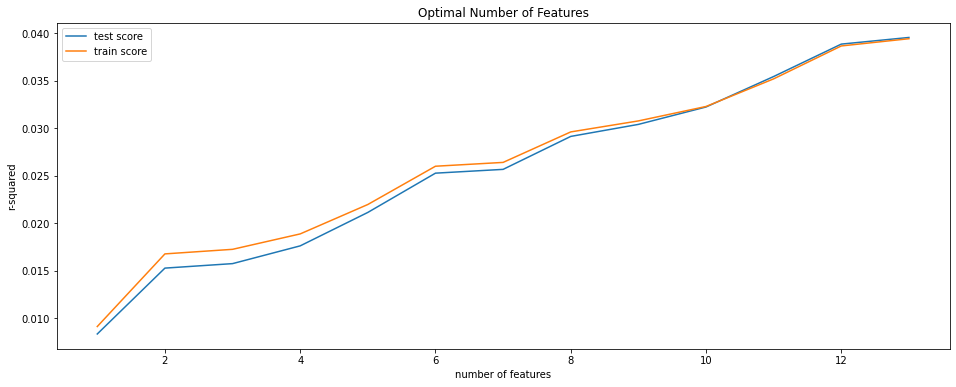

In [10]:

n_features_optimal = 10

lm = LinearRegression()
lm.fit(X_train, y_train)

rfe = RFE(lm, n_features_to_select=n_features_optimal)             
rfe = rfe.fit(X_train, y_train)

# predict prices of X_test
y_pred = lm.predict(X_test)
r2 = sklearn.metrics.r2_score(y_test, y_pred)
print(r2)

0.05379055551551293


In [ ]:
# If diverge can use lasso or ridge